In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


## Generate Data
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float)
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)

slab_df = 4
slab_scale = 2

## Do Bayesian Sindy
def predator_prey_sunode_library(t, y, p):
    du_dt = p.pn[0] * y.u + p.pn[2] * y.v + p.pn[4] * y.u * y.v + p.pn[6] * y.u**2 + p.pn[8]* y.v**2 - 1e-5 * y.u**3
    dv_dt = p.pn[1] * y.u + p.pn[3] * y.v + p.pn[5] * y.u * y.v + p.pn[7] * y.u**2 + p.pn[9]*y.v**2 - 1e-5 * y.v**3
    return {'u': du_dt, 'v' : dv_dt}

model_sunode = pm.Model()

with model_sunode:

    sigma = pm.Lognormal('sigma', mu=-1, sigma=0.1, shape=2)
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=10)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.01)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = (pm.math.sqrt(c2)*l) / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=10)
    pn = pm.Deterministic('pn', z*tau*lt)
    #pn = pm.Normal('pn', mu=0, sigma=tau*l, shape=10)
    
    y0 = pm.Lognormal('y0', mu=pm.math.log(1), sigma=1, shape=2)

    y_hat = sun.solve_ivp(
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,10),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=predator_prey_sunode_library,
    make_solver='BDF',
            tvals=times,
            t0=times[0],
        )[0]

    uobs = pm.Lognormal('uobs', mu=pm.math.log(y_hat['u'][:]), sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Lognormal('vobs', mu=pm.math.log(y_hat['v'][:]), sigma=sigma[1], observed=yobs_norm[:,1])

with model_sunode:
    trace = pm.backends.load_trace('real_rh_test_1' + '.trace', model_sunode)

print('real_rh')
print('done')

real_rh
done


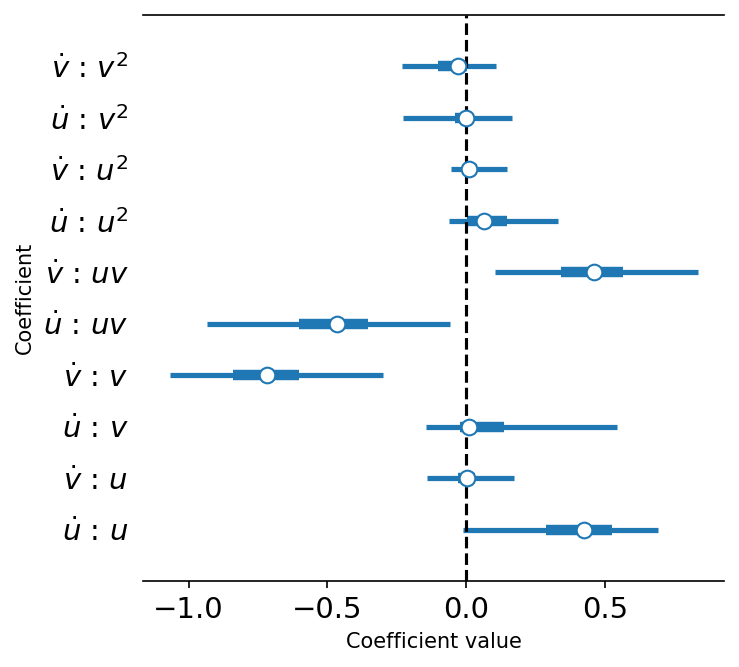

In [2]:
fig = plt.figure(figsize=(5, 5), dpi=150)
ax = plt.axes()
ax.plot([0, 0], [-0.05, 0.5], 'k--')
out = pm.forestplot(trace['pn'].T, credible_interval=0.95, linewidth=2.5, markersize=10, ax=ax)
ax.set_title('')
ax.set_xlabel('Coefficient value')
ax.set_ylabel('Coefficient')
ax.set_xlim(-1.2, 1.0)
ax.set_ylim(-0.05, 0.5)
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45])
ax.set_yticklabels([r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$'])
plt.show()
fig.savefig('real_rh_forestplot.png', bbox_inches='tight')